In [1]:
# import basic modules
import sys
import os
import time
import numpy as np
from tqdm import tqdm
import gc
import torch
import argparse
import skimage.transform

# import custom modules
code_dir = '/user_data/mmhender/imStat/code/'
sys.path.append(code_dir)
from feature_extraction import sketch_token_features
from utils import nsd_utils, roi_utils, default_paths

from model_fitting import initialize_fitting as initialize_fitting
import matplotlib.pyplot as plt

fpX = np.float32
device = 'cpu:0'

In [2]:
def gauss_1d(x,center,sigma):    
    y = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(1/2)*((x-center)/sigma)**2)    
    return y

def von_mises_deg(xx,mu,k,a=1,b=0):
  # make a von mises function over the range in xx
  # assume the input is 0-180 or 0-360 deg space.
    axis_size_deg = np.max(xx)+1
    if k<10**(-15):
        print('WARNING: k is too small, might get precision errors')
    
    xx_rad2pi = np.float128(xx/axis_size_deg*2*np.pi)
    mu_rad2pi = mu/axis_size_deg*2*np.pi
    yy = np.exp(k*(np.cos(xx_rad2pi-mu_rad2pi)-1))

    # first make the y values span from 0-1
    yy = yy-min(yy)
    yy = yy/max(yy)

    # then apply the entered amplitude and baseline.
    yy = a*yy+b

    return yy

In [3]:
# tuning_dist_centers = [45,135]
tuning_dist_centers = [0,90]
tuning_dist_ks = [10,10]
stim_axis = np.arange(0,180)
base = 0.10
g = np.array([von_mises_deg(stim_axis, tuning_dist_centers[ii], tuning_dist_ks[ii]) \
              for ii in range(len(tuning_dist_centers))])
tuning_dist = np.sum(g, axis=0) + base
tuning_dist /= np.sum(tuning_dist)

In [4]:
n_voxels = 1000
voxel_prefs = np.random.choice(stim_axis,size=(n_voxels,), replace=True, \
                               p=tuning_dist.astype('float64'))
voxel_ks = np.ones((n_voxels,))*10

voxel_tc = np.array([von_mises_deg(stim_axis, voxel_prefs[vv], voxel_ks[vv]) \
                     for vv in range(n_voxels)])
voxel_tc /= np.tile(np.sum(voxel_tc, axis=1, keepdims=True), [1,voxel_tc.shape[1]])

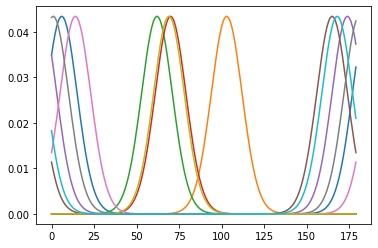

In [5]:
plt.figure();
for vv in range(10):
    plt.plot(stim_axis, voxel_tc[vv,:])

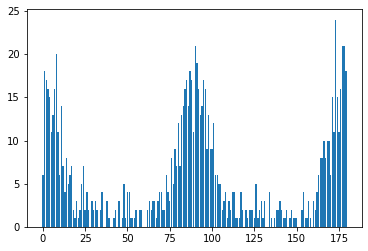

In [6]:
plt.figure();
n_each = np.array([np.sum(voxel_prefs==ii) for ii in stim_axis])
plt.bar(stim_axis, n_each);

In [7]:
prior_dist = np.ones((180,))/180

n_trials = 800;
trial_stims = np.random.choice(stim_axis,size=(n_trials,), replace=True, \
                               p=prior_dist.astype('float64'))

design_matrix = np.zeros((n_trials, len(stim_axis)))
for tt in range(n_trials):
    ind = np.where(trial_stims[tt]==stim_axis)[0][0]
    design_matrix[tt,ind] = 1;
assert(all(np.sum(design_matrix, axis=1)==1))

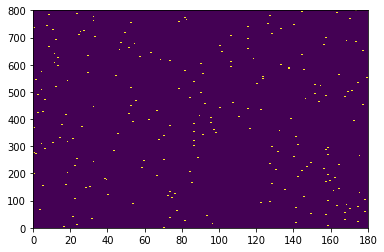

In [8]:
plt.figure();
plt.pcolormesh(design_matrix)

In [9]:
noiseless_resp = voxel_tc @ design_matrix.T
noise_sigma = 0.0
noisy_resp = noiseless_resp + np.random.normal(0,noise_sigma, np.shape(noiseless_resp))

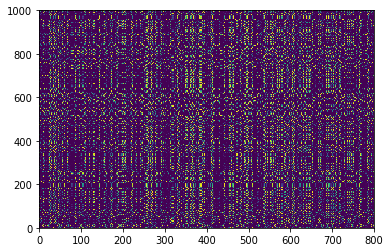

In [10]:
plt.figure();
plt.pcolormesh(noisy_resp)

In [11]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(noisy_resp.T)
scores = pca.transform(noisy_resp.T)
scores.shape
pca_wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

In [12]:
scores.shape

(800, 800)

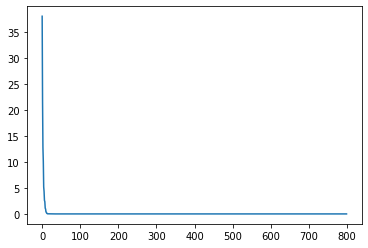

In [13]:
plt.figure();
plt.plot(ev)

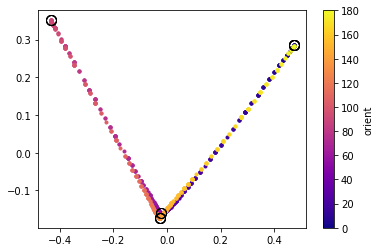

In [14]:
fig = plt.figure();
from matplotlib import cm
import matplotlib
colors = cm.plasma(np.linspace(0,1,180))
for oo in range(180):
    inds = trial_stims==oo
    plt.plot(scores[inds,0], scores[inds,1],'.',color=colors[oo])
    
for oo in [0,45,90,135,180]:
    inds = trial_stims==oo
    plt.plot(scores[inds,0], scores[inds,1],'o',markeredgecolor='k',markerfacecolor="None",markersize=10)

scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0, vmax=180),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='orient')


In [15]:

# main_axis = np.random.normal(0,1,(150,))
# main_axis = main_axis / np.sqrt(np.sum(main_axis**2))
# n_voxels = 1000;
# angle_axis = np.arange(0,180)
# angle_distrib = gauss_1d(angle_axis,0,5) + 0.01
# angle_distrib /= np.sum(angle_distrib)
# voxel_angles = np.random.choice(angle_axis, size=(n_voxels,),replace=True, p = angle_distrib.astype('float64'))


In [161]:
# instead of von-mises, going to create ramp-like tuning functions for voxels that are non-uniformly 
# distributed around full feature space.
n_voxels = 1000;
main_axis = np.zeros((180,))
main_axis[0] = 1
prop_aligned = 0.30
# prop_aligned = 1/180
voxel_tuning_axes = np.zeros((n_voxels,180))
for vv in range(n_voxels):
    if np.random.uniform(0,1,1)>prop_aligned:
        ind = np.random.choice(np.arange(1,180),1)
    else:
        ind = 0
    voxel_tuning_axes[vv,ind] = 1
    
# voxel_tuning_axes += np.random.normal(0,1,voxel_tuning_axes.shape)*0.1

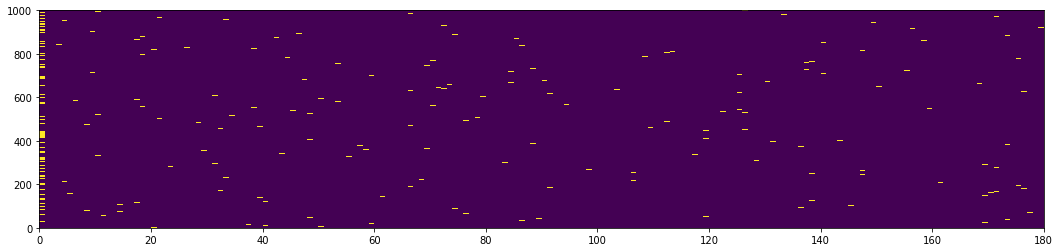

In [162]:
plt.figure(figsize=(18,4));
plt.pcolormesh(voxel_tuning_axes)

In [163]:
stim_axis = np.arange(180)
prior_dist = np.ones((180,))/180

n_trials = 800;
trial_stims = np.random.choice(stim_axis,size=(n_trials,), replace=True, \
                               p=prior_dist.astype('float64'))

design_matrix = np.zeros((n_trials, len(stim_axis)))
for tt in range(n_trials):
    ind = np.where(trial_stims[tt]==stim_axis)[0][0]
    design_matrix[tt,ind] = 1;
#     design_matrix[tt,:] = gauss_1d(stim_axis,trial_stims[tt],2)
#     design_matrix[tt,np.mod(ind-1,180)] = 0.5
#     design_matrix[tt,np.mod(ind+1,180)] = 0.5
assert(all(np.sum(design_matrix, axis=1)==1))

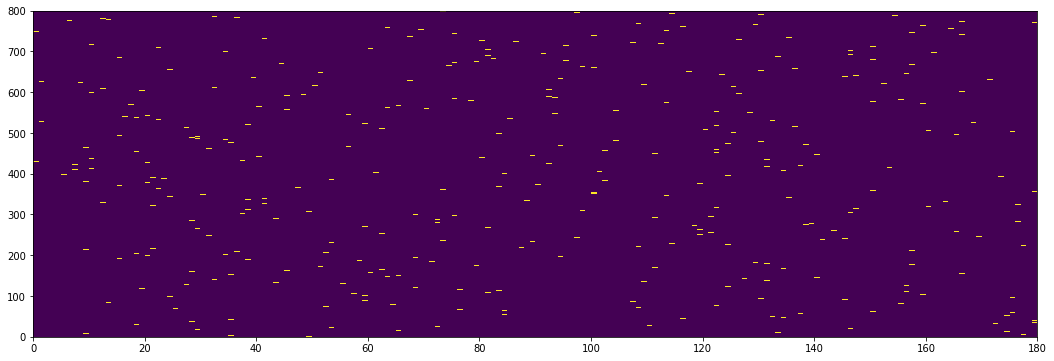

In [164]:
plt.figure(figsize=(18,6));
plt.pcolormesh(design_matrix)

In [165]:
noiseless_resp = voxel_tuning_axes @ design_matrix.T
noise_sigma = 0.00
noisy_resp = noiseless_resp + np.random.normal(0,noise_sigma, np.shape(noiseless_resp))
noisy_resp = noisy_resp.T

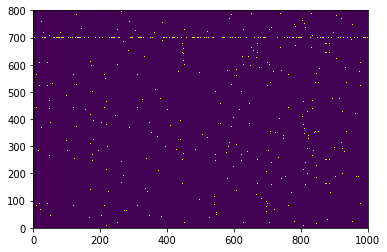

In [166]:
plt.figure();
plt.pcolormesh(noisy_resp)

In [167]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(noisy_resp)
scores = pca.transform(noisy_resp)
scores.shape
pca_wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

In [168]:
noisy_resp.shape

(800, 1000)

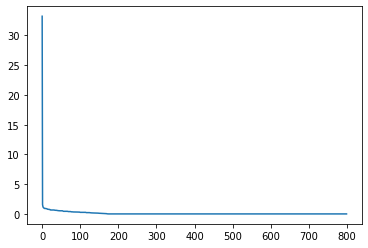

In [169]:
plt.figure();
plt.plot(ev)

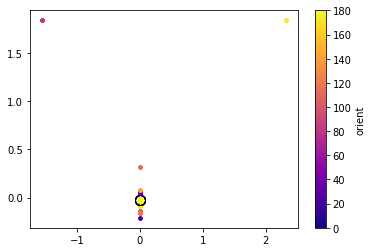

In [160]:
fig = plt.figure();
from matplotlib import cm
import matplotlib

pc2plot = [4,5]
colors = cm.plasma(np.linspace(0,1,180))
for oo in range(180):
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'.',color=colors[oo])
    
for oo in [0]:
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'o',markeredgecolor='k',markerfacecolor="None",markersize=10)

scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0, vmax=180),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='orient')


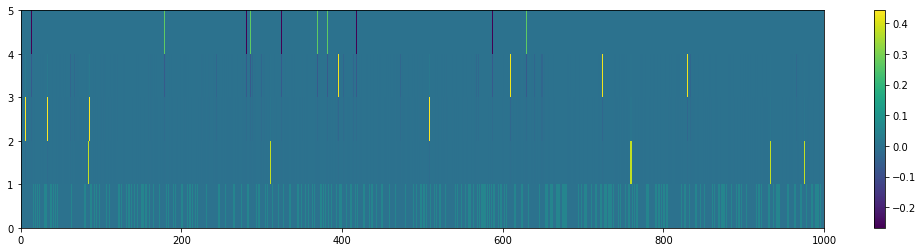

In [116]:
plt.figure(figsize=(18,4));
plt.pcolormesh(pca_wts[0:5,:]);
plt.colorbar()

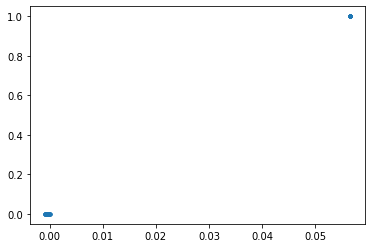

In [118]:
plt.figure();
plt.plot(pca_wts[0,:], voxel_tuning_axes[:,0],'.')

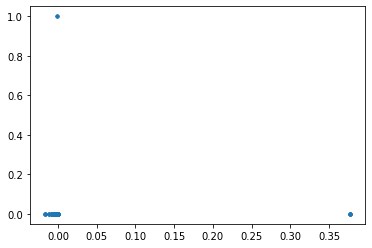

In [119]:
plt.figure();
plt.plot(pca_wts[1,:], voxel_tuning_axes[:,1],'.')

In [170]:
# instead of von-mises, going to create ramp-like tuning functions for voxels that are non-uniformly 
# distributed around full feature space.
n_voxels = 180*5;
main_axis = np.zeros((180,))
main_axis[0] = 1
voxel_tuning_axes = np.zeros((n_voxels,180))
for vv in range(n_voxels):
    ind = np.mod(vv, 180)
    voxel_tuning_axes[vv,ind] = 1
    
# voxel_tuning_axes += np.random.normal(0,1,voxel_tuning_axes.shape)*0.1

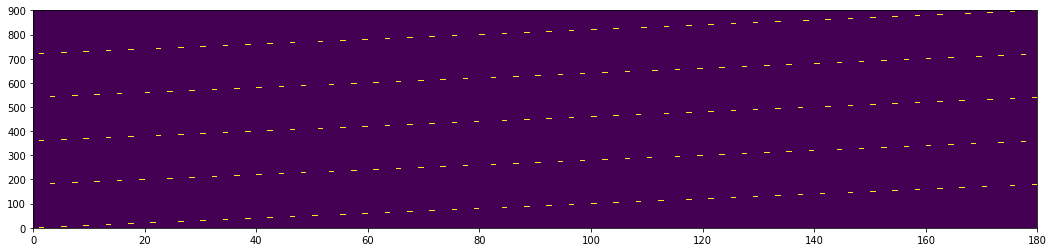

In [171]:
plt.figure(figsize=(18,4));
plt.pcolormesh(voxel_tuning_axes)

In [176]:

n_trials = 180*5;
design_matrix = np.zeros((n_trials,180))
for tt in range(n_trials):
    ind = np.mod(tt, 180)
    design_matrix[tt,ind] = 1

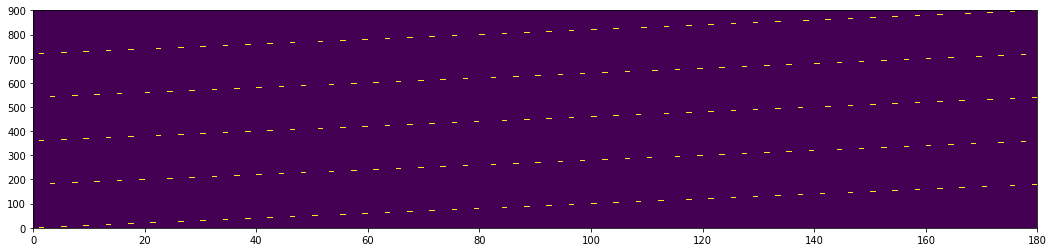

In [183]:
plt.figure(figsize=(18,4));
plt.pcolormesh(design_matrix)

In [178]:
noiseless_resp = voxel_tuning_axes @ design_matrix.T
noise_sigma = 0.00
noisy_resp = noiseless_resp + np.random.normal(0,noise_sigma, np.shape(noiseless_resp))
noisy_resp = noisy_resp.T

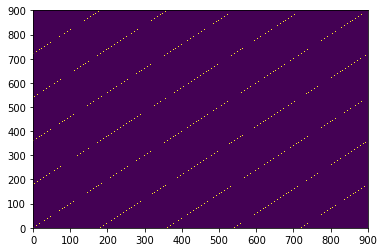

In [179]:
plt.figure();
plt.pcolormesh(noisy_resp)

In [180]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(noisy_resp)
scores = pca.transform(noisy_resp)
scores.shape
pca_wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

In [181]:
noisy_resp.shape

(900, 900)

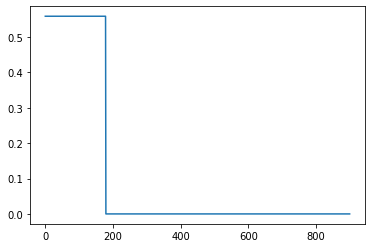

In [182]:
plt.figure();
plt.plot(ev)

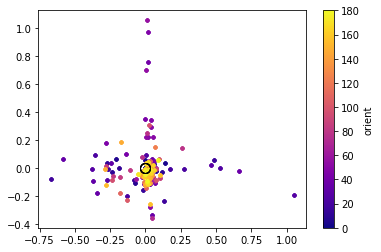

In [188]:
fig = plt.figure();
from matplotlib import cm
import matplotlib

pc2plot = [0,1]
colors = cm.plasma(np.linspace(0,1,180))
trial_stims = np.argmax(design_matrix, axis=1)
for oo in range(180):
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'.',color=colors[oo])
    
for oo in [0]:
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'o',markeredgecolor='k',markerfacecolor="None",markersize=10)

scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0, vmax=180),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='orient')


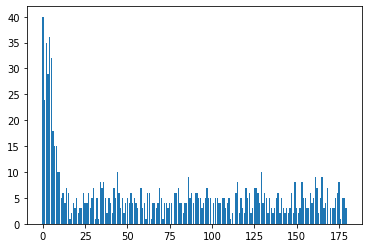

In [16]:
# plt.figure();
# n_each = np.array([np.sum(voxel_angles==ii) for ii in angle_axis])
# plt.bar(angle_axis, n_each);

In [ ]:
# angle = 45
# cosangle = np.cos(angle*np.pi/180)
# print(cosangle)
# voxel_tuning_axis = cosangle * np.linalg.pinv(main_axis[:,np.newaxis])
# voxel_tuning_axis = np.squeeze(voxel_tuning_axis)
# voxel_tuning_axis = voxel_tuning_axis/np.sqrt(np.sum(voxel_tuning_axis**2))**(0.5)
# print(voxel_tuning_axis @ main_axis)

In [ ]:
# maxiter = 10000
# desired_angle=20
# good = np.abs(angle-desired_angle)<0.1
# ii=0
# while ~good and ii<maxiter:
#     ii+=1
#     ind2perturb = np.random.choice(len(main_axis),1)
#     perturb_value = np.random.normal(0,1,)

In [27]:
# tuning_dist_centers = [45,135]
tuning_dist_centers = [120]
# tuning_dist_ks = [10]
tuning_dist_sigmas = [5]
stim_axis = np.arange(0,180)
base = 0.05
g = np.array([gauss_1d(stim_axis, tuning_dist_centers[ii], tuning_dist_sigmas[ii]) \
              for ii in range(len(tuning_dist_centers))])
tuning_dist = np.sum(g, axis=0) + base
tuning_dist /= np.sum(tuning_dist)

In [28]:
n_voxels = 1000
voxel_prefs = np.random.choice(stim_axis,size=(n_voxels,), replace=True, \
                               p=tuning_dist.astype('float64'))
# voxel_ks = np.ones((n_voxels,))*10
voxel_sigmas = np.ones((n_voxels,))*0.1
voxel_tc = np.array([gauss_1d(stim_axis, voxel_prefs[vv], voxel_sigmas[vv]) \
                     for vv in range(n_voxels)])
# voxel_tc /= np.tile(np.sum(voxel_tc, axis=1, keepdims=True), [1,voxel_tc.shape[1]])

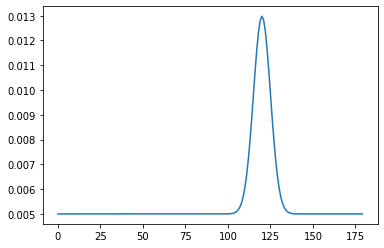

In [29]:
plt.figure();
plt.plot(stim_axis,tuning_dist)

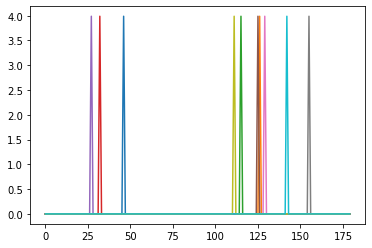

In [307]:
plt.figure();
for vv in range(10):
    plt.plot(stim_axis, voxel_tc[vv,:])

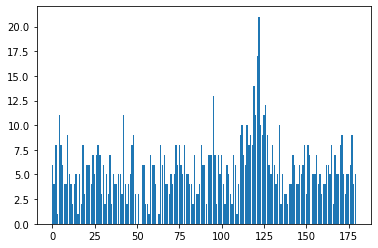

In [308]:
plt.figure();
n_each = np.array([np.sum(voxel_prefs==ii) for ii in stim_axis])
plt.bar(stim_axis, n_each);

In [309]:
prior_dist = np.ones((180,))/180

n_trials = 800;
trial_stims = np.random.choice(stim_axis,size=(n_trials,), replace=True, \
                               p=prior_dist.astype('float64'))

design_matrix = np.zeros((n_trials, len(stim_axis)))
for tt in range(n_trials):
    ind = np.where(trial_stims[tt]==stim_axis)[0][0]
    design_matrix[tt,ind] = 1;
    design_matrix[tt,:] = gauss_1d(stim_axis,trial_stims[tt],2)
#     design_matrix[tt,np.mod(ind-1,180)] = 0.5
#     design_matrix[tt,np.mod(ind+1,180)] = 0.5
# assert(all(np.sum(design_matrix, axis=1)==1))

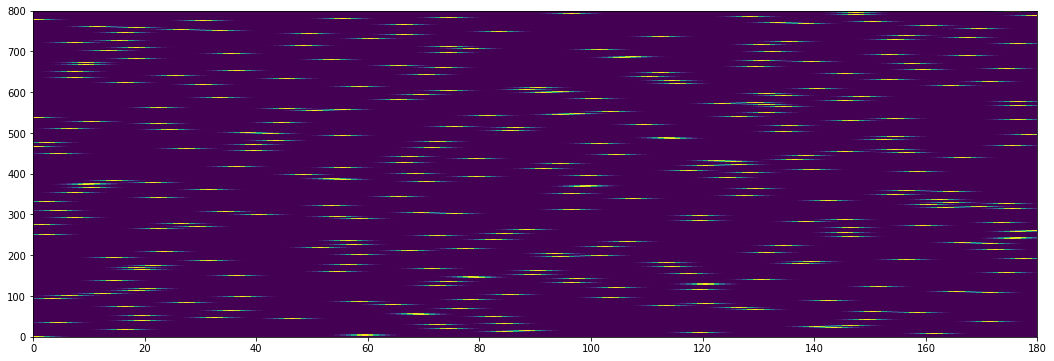

In [310]:
plt.figure(figsize=(18,6));
plt.pcolormesh(design_matrix)

In [311]:
noiseless_resp = voxel_tc @ design_matrix.T
noise_sigma = 0.0
noisy_resp = noiseless_resp + np.random.normal(0,noise_sigma, np.shape(noiseless_resp))

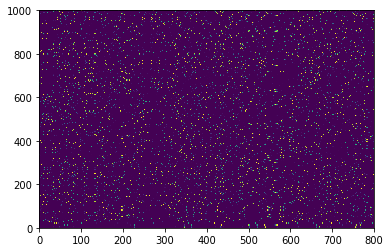

In [313]:
plt.figure();
plt.pcolormesh(noisy_resp)

In [314]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(noisy_resp.T)
scores = pca.transform(noisy_resp.T)
scores.shape
pca_wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

In [315]:
scores.shape

(800, 800)

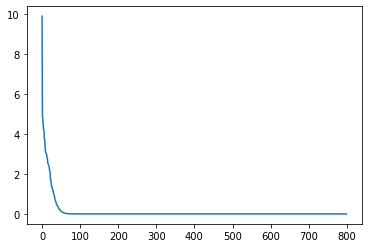

In [316]:
plt.figure();
plt.plot(ev)

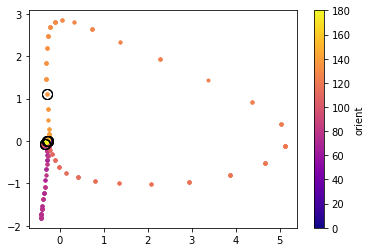

In [318]:
fig = plt.figure();
from matplotlib import cm
import matplotlib

pc2plot = [0,1]
colors = cm.plasma(np.linspace(0,1,180))
for oo in range(180):
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'.',color=colors[oo])
    
for oo in [0,45,90,135,180]:
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'o',markeredgecolor='k',markerfacecolor="None",markersize=10)

scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0, vmax=180),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='orient')


In [319]:
# tuning_dist_centers = [45,135]
tuning_dist_centers = [120]
# tuning_dist_ks = [10]
tuning_dist_sigmas = [5]
stim_axis = np.arange(0,180)
base = 0.05
g = np.array([gauss_1d(stim_axis, tuning_dist_centers[ii], tuning_dist_sigmas[ii]) \
              for ii in range(len(tuning_dist_centers))])
tuning_dist = np.sum(g, axis=0) + base
tuning_dist /= np.sum(tuning_dist)

In [305]:
n_voxels = 1000
voxel_prefs = np.random.choice(stim_axis,size=(n_voxels,), replace=True, \
                               p=tuning_dist.astype('float64'))
# voxel_ks = np.ones((n_voxels,))*10
voxel_sigmas = np.ones((n_voxels,))*0.1
voxel_tc = np.zeros((n_voxels,len(stim_axis)))
for voxel_tc
voxel_tc[vv,]
                    
# voxel_tc /= np.tile(np.sum(voxel_tc, axis=1, keepdims=True), [1,voxel_tc.shape[1]])

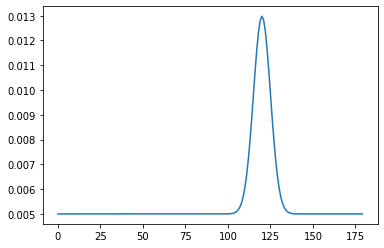

In [306]:
plt.figure();
plt.plot(stim_axis,tuning_dist)

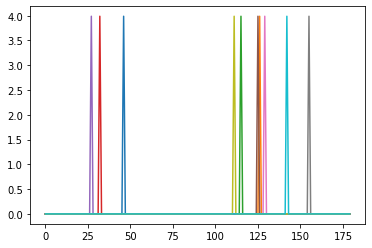

In [307]:
plt.figure();
for vv in range(10):
    plt.plot(stim_axis, voxel_tc[vv,:])

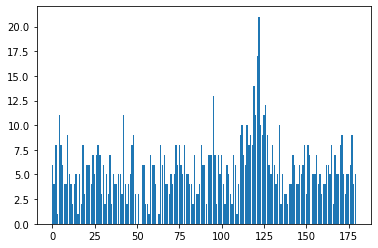

In [308]:
plt.figure();
n_each = np.array([np.sum(voxel_prefs==ii) for ii in stim_axis])
plt.bar(stim_axis, n_each);

In [309]:
prior_dist = np.ones((180,))/180

n_trials = 800;
trial_stims = np.random.choice(stim_axis,size=(n_trials,), replace=True, \
                               p=prior_dist.astype('float64'))

design_matrix = np.zeros((n_trials, len(stim_axis)))
for tt in range(n_trials):
    ind = np.where(trial_stims[tt]==stim_axis)[0][0]
    design_matrix[tt,ind] = 1;
    design_matrix[tt,:] = gauss_1d(stim_axis,trial_stims[tt],2)
#     design_matrix[tt,np.mod(ind-1,180)] = 0.5
#     design_matrix[tt,np.mod(ind+1,180)] = 0.5
# assert(all(np.sum(design_matrix, axis=1)==1))

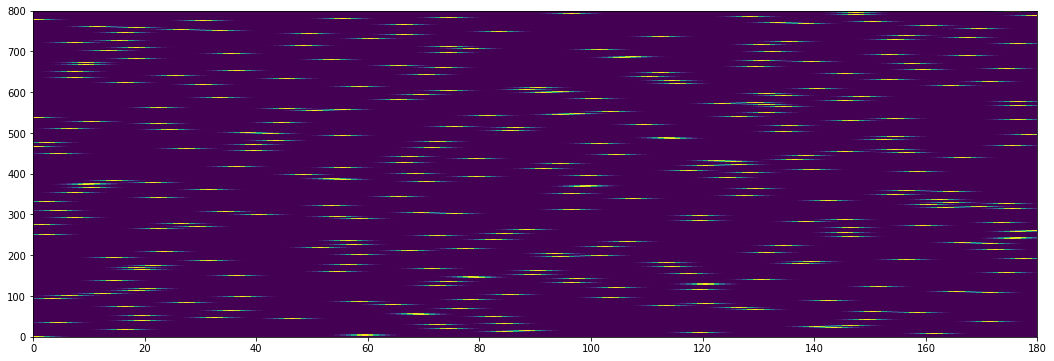

In [310]:
plt.figure(figsize=(18,6));
plt.pcolormesh(design_matrix)

In [311]:
noiseless_resp = voxel_tc @ design_matrix.T
noise_sigma = 0.0
noisy_resp = noiseless_resp + np.random.normal(0,noise_sigma, np.shape(noiseless_resp))

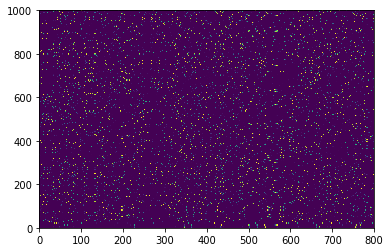

In [313]:
plt.figure();
plt.pcolormesh(noisy_resp)

In [314]:
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(noisy_resp.T)
scores = pca.transform(noisy_resp.T)
scores.shape
pca_wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100

In [315]:
scores.shape

(800, 800)

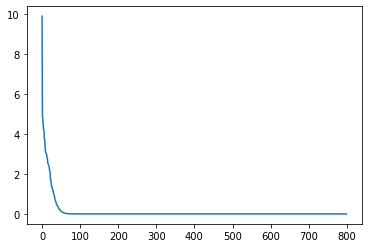

In [316]:
plt.figure();
plt.plot(ev)

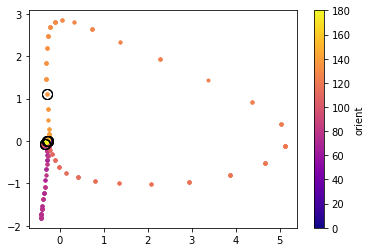

In [318]:
fig = plt.figure();
from matplotlib import cm
import matplotlib

pc2plot = [0,1]
colors = cm.plasma(np.linspace(0,1,180))
for oo in range(180):
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'.',color=colors[oo])
    
for oo in [0,45,90,135,180]:
    inds = trial_stims==oo
    plt.plot(scores[inds,pc2plot[0]], scores[inds,pc2plot[1]],'o',markeredgecolor='k',markerfacecolor="None",markersize=10)

scalmap = cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0, vmax=180),\
                  cmap='plasma')
fig.colorbar(scalmap, orientation='vertical', label='orient')
